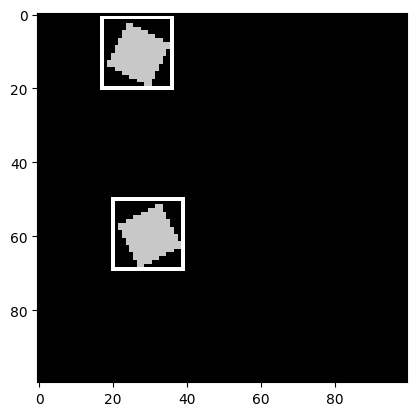

In [ ]:
from torch import nn
import torch
import torchvision
import matplotlib.pyplot as plt
import square_data_generator
from torchvision.utils import draw_bounding_boxes
import torch
import torch.nn.functional as F
import utils
import tqdm
import pred_model
from scipy.optimize import linear_sum_assignment
import itertools
from square_data_generator import label_sort_order_big_to_small


N_SQUARES = 3
IMAGE_SIZE = (100, 100)

test_img, test_bboxes, test_colors = square_data_generator.make_image(
    IMAGE_SIZE, N_SQUARES
)
pred_points = torchvision.ops.box_convert(test_bboxes, in_fmt="cxcywh", out_fmt="xyxy")

img_with_boxes = draw_bounding_boxes(
    (test_img.permute(2, 0, 1) * 255).to(torch.uint8),
    pred_points,
    colors=test_colors,
    width=1,
)
plt.imshow(img_with_boxes.permute(1, 2, 0));

In [2]:
def ordered_loss_big_to_small(
    predicted_bboxes: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    _loss = 0

    for batch_idx in range(predicted_bboxes.size(0)):
        # sort_idx = label_sort_order_big_to_small(predicted_bboxes[batch_idx])
        for idx in range(N_SQUARES):
            _loss += nn.functional.mse_loss(
                predicted_bboxes[0, idx], target_bboxes[batch_idx][idx]
            )
    return _loss


def point_matching_loss_greedy(
    pred_points: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    target_points = target_bboxes[:, :, :2]

    batch_size = pred_points.size(0)

    # greedy matching step
    removed = torch.zeros(N_SQUARES, dtype=torch.bool)

    loss = 0
    for batch_idx in range(batch_size):
        for idx in torch.randperm(N_SQUARES):  # random shuffle predicted bboxes]:
            # find the target bbox with the smallest L2 distance
            diff = target_points[batch_idx] - pred_points[batch_idx, idx]
            dists = torch.norm(diff, dim=1, p=2)
            dists[removed] = float("inf")  # set removed ones' distance to inf

            best_match_idx = torch.argmin(dists)
            removed[best_match_idx] = True

            loss += nn.functional.mse_loss(
                pred_points[batch_idx, idx], target_points[batch_idx, best_match_idx]
            )

    return loss


def point_matching_loss_2_brute(
    pred_points: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    target_points = target_bboxes[:, :, :2]

    batch_size = pred_points.size(0)

    chosen_scores = torch.zeros(batch_size)

    for batch_idx in range(batch_size):
        perms = torch.tensor(list(itertools.permutations(range(N_SQUARES))))
        perm_scores = torch.zeros(perms.size(0))

        for i, perm in enumerate(perms):
            diff = target_points[batch_idx] - pred_points[batch_idx, perm]
            dists = torch.norm(diff, dim=1, p=2)
            loss = dists.sum()
            perm_scores[i] = loss

        chosen_scores[batch_idx] = torch.min(perm_scores)

    return chosen_scores.sum()


def calculate_iou_cxcywh(
    pred_boxes: torch.Tensor, target_boxes: torch.Tensor
) -> torch.Tensor:
    """
    Calculate IoU for bounding boxes in cxcywh format
    Boxes are expected in format [center_x, center_y, width, height]
    """
    # Convert cxcywh to corner coordinates
    pred_cx, pred_cy, pred_w, pred_h = pred_boxes.unbind(-1)
    targ_cx, targ_cy, targ_w, targ_h = target_boxes.unbind(-1)

    # Calculate corner coordinates
    pred_x1 = pred_cx - pred_w / 2
    pred_y1 = pred_cy - pred_h / 2
    pred_x2 = pred_cx + pred_w / 2
    pred_y2 = pred_cy + pred_h / 2

    targ_x1 = targ_cx - targ_w / 2
    targ_y1 = targ_cy - targ_h / 2
    targ_x2 = targ_cx + targ_w / 2
    targ_y2 = targ_cy + targ_h / 2

    # Calculate intersection coordinates
    inter_x1 = torch.max(pred_x1, targ_x1)
    inter_y1 = torch.max(pred_y1, targ_y1)
    inter_x2 = torch.min(pred_x2, targ_x2)
    inter_y2 = torch.min(pred_y2, targ_y2)

    # Calculate intersection area
    inter_width = torch.clamp(inter_x2 - inter_x1, min=0)
    inter_height = torch.clamp(inter_y2 - inter_y1, min=0)
    inter_area = inter_width * inter_height

    # Calculate union area
    pred_area = pred_w * pred_h
    targ_area = targ_w * targ_h
    union_area = pred_area + targ_area - inter_area

    # Calculate IoU
    iou = inter_area / (union_area + 1e-6)  # Add epsilon to avoid division by zero
    return iou


def ordered_iou_loss_big_to_small(
    predicted_bboxes: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    """
    Calculate IoU loss for ordered bounding boxes in cxcywh format
    Args:
        predicted_bboxes: Tensor of shape (batch_size, num_boxes, 4) in [cx, cy, w, h]
        target_bboxes: Tensor of shape (batch_size, num_boxes, 4) in [cx, cy, w, h]
    Returns:
        Total IoU loss
    """
    _loss = 0.0

    for batch_idx in range(predicted_bboxes.size(0)):
        for idx in range(5):  # Assuming 5 boxes as in original code
            # Calculate IoU for each pair of boxes
            iou = calculate_iou_cxcywh(
                predicted_bboxes[batch_idx, idx], target_bboxes[batch_idx, idx]
            )
            # Convert IoU to loss (1 - IoU)
            box_loss = 1 - iou
            _loss += box_loss

    return _loss


In [3]:
train_dataset = square_data_generator.SquareDataset(
    image_size=(100, 100),
    num_boxes=N_SQUARES,
    num_samples=2000,
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

test_dataset = square_data_generator.SquareDataset(
    image_size=(100, 100),
    num_boxes=N_SQUARES,
    num_samples=100,
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

In [4]:
def point_matching_loss_optimal(
    pred_points: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    """
    Compute the matching loss between pred_points and target_bboxes using
    a global optimal assignment (Hungarian algorithm) for each batch element.

    Args:
        pred_points: shape (batch_size, N, 2)
        target_bboxes: shape (batch_size, N, 4) or (batch_size, N, 2 + anything).
                       We only use the first two columns as (x, y).
    Returns:
        total_loss: scalar tensor (sum of MSE across all matched pairs in the entire batch).
    """
    # Only keep the (x, y) part of the target
    target_points = target_bboxes[..., :2]

    # Randomly shuffle predicted bboxes across the batch dim
    # ( If you intended to shuffle per-batch differently, you'd do it per index;
    #   but here it follows your original code's single permutation. )
    batch_perm = torch.randperm(pred_points.size(0))
    pred_points = pred_points[batch_perm]

    batch_size, n_squares, _ = pred_points.shape
    total_loss = 0.0

    for b_idx in range(batch_size):
        # Compute cost matrix of shape (n_squares, n_squares) = squared distances
        # We can use torch.cdist(..., p=2) then square it, or directly compute squared distances
        # cost[i, j] = ||pred_i - target_j||^2
        diff = pred_points[b_idx].unsqueeze(1) - target_points[b_idx].unsqueeze(0)
        # cost_matrix = (diff**2).sum(dim=-1)  # shape: [N, N]
        cost_matrix = (diff.abs()).sum(dim=-1)  # shape: [N, N]

        # Hungarian algorithm: find minimal-cost assignment
        # linear_sum_assignment expects a NumPy array on CPU
        row_ind, col_ind = linear_sum_assignment(cost_matrix.cpu().detach().numpy())

        # Matched pairs: pred_points[b_idx, row_ind] and target_points[b_idx, col_ind]
        matched_pred = pred_points[b_idx, row_ind]
        matched_tgt = target_points[b_idx, col_ind]

        # ----
        # Replicate what your original loop-based code does with
        # nn.functional.mse_loss(...). By default, F.mse_loss uses "mean" over features,
        # and you were summing over squares. So let's replicate that carefully.
        #
        # For each pair, your original code does:
        #     loss += mse_loss(pred[i], target[i])  # which is mean((x1 - x2)^2 + (y1 - y2)^2)
        # Then you sum that across all squares. So effectively you get
        # sum_{i=1..N} ( (dx_i^2 + dy_i^2)/2 ).
        #
        # We can do the same in a vectorized way:

        # mse_per_pair shape [N, 2] -> we mean over dim=1 (the 2D coords), giving shape [N]
        mse_per_pair = F.mse_loss(matched_pred, matched_tgt, reduction="none").mean(
            dim=1
        )

        # Sum across all matched pairs
        total_loss += mse_per_pair.sum()

    return total_loss


In [ ]:
# Training parameters

num_epochs = 100
learning_rate = 0.001

# Initialize model, loss function, and optimizer
model = pred_model.ParallelPointPredictor(n_outputs=N_SQUARES)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

test_images = []

# Training loop
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.eval()
    with torch.no_grad():
        test_pred_points = model(test_img.permute(2, 0, 1).unsqueeze(0))
        test_images.append(
            utils.draw_points_on_image(test_img.numpy(), test_pred_points[0])
        )

    test_loss = 0.0
    for images, target_bboxes in test_dataloader:
        pred_points = model(images)
        loss = point_matching_loss_2_brute(pred_points, target_bboxes)
        test_loss += loss.item()
        # 1 / 0
    test_losses.append(test_loss / len(test_dataloader))

    model.train()
    running_loss = 0.0

    for images, target_bboxes in tqdm.tqdm(train_dataloader):
        #### override data to be the test image
        # images = test_img.permute(2, 0, 1).unsqueeze(0)
        # target_bboxes = test_bboxes.unsqueeze(0)
        ###
        optimizer.zero_grad()
        pred_points = model(images)
        loss = point_matching_loss_2_brute(pred_points, target_bboxes)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_dataloader))

    # Early stopping condition
    if epoch > 4 and min(test_losses[-5:]) > min(test_losses):
        print(f"Early stopping at epoch {epoch} due to no improvement in test loss.")
        break

# save weights:
torch.save(model.state_dict(), f"{str(model)}_weights.pth")
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(train_losses, label="train")
ax.plot(test_losses, label="test")
ax.set_xticks(range(len(train_losses)))
ax.legend()

plt.show();

/var/folders/vc/1d1z34l176gfm4swwfttvslr0000gn/T/ipykernel_14517/1935486990.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{str(model

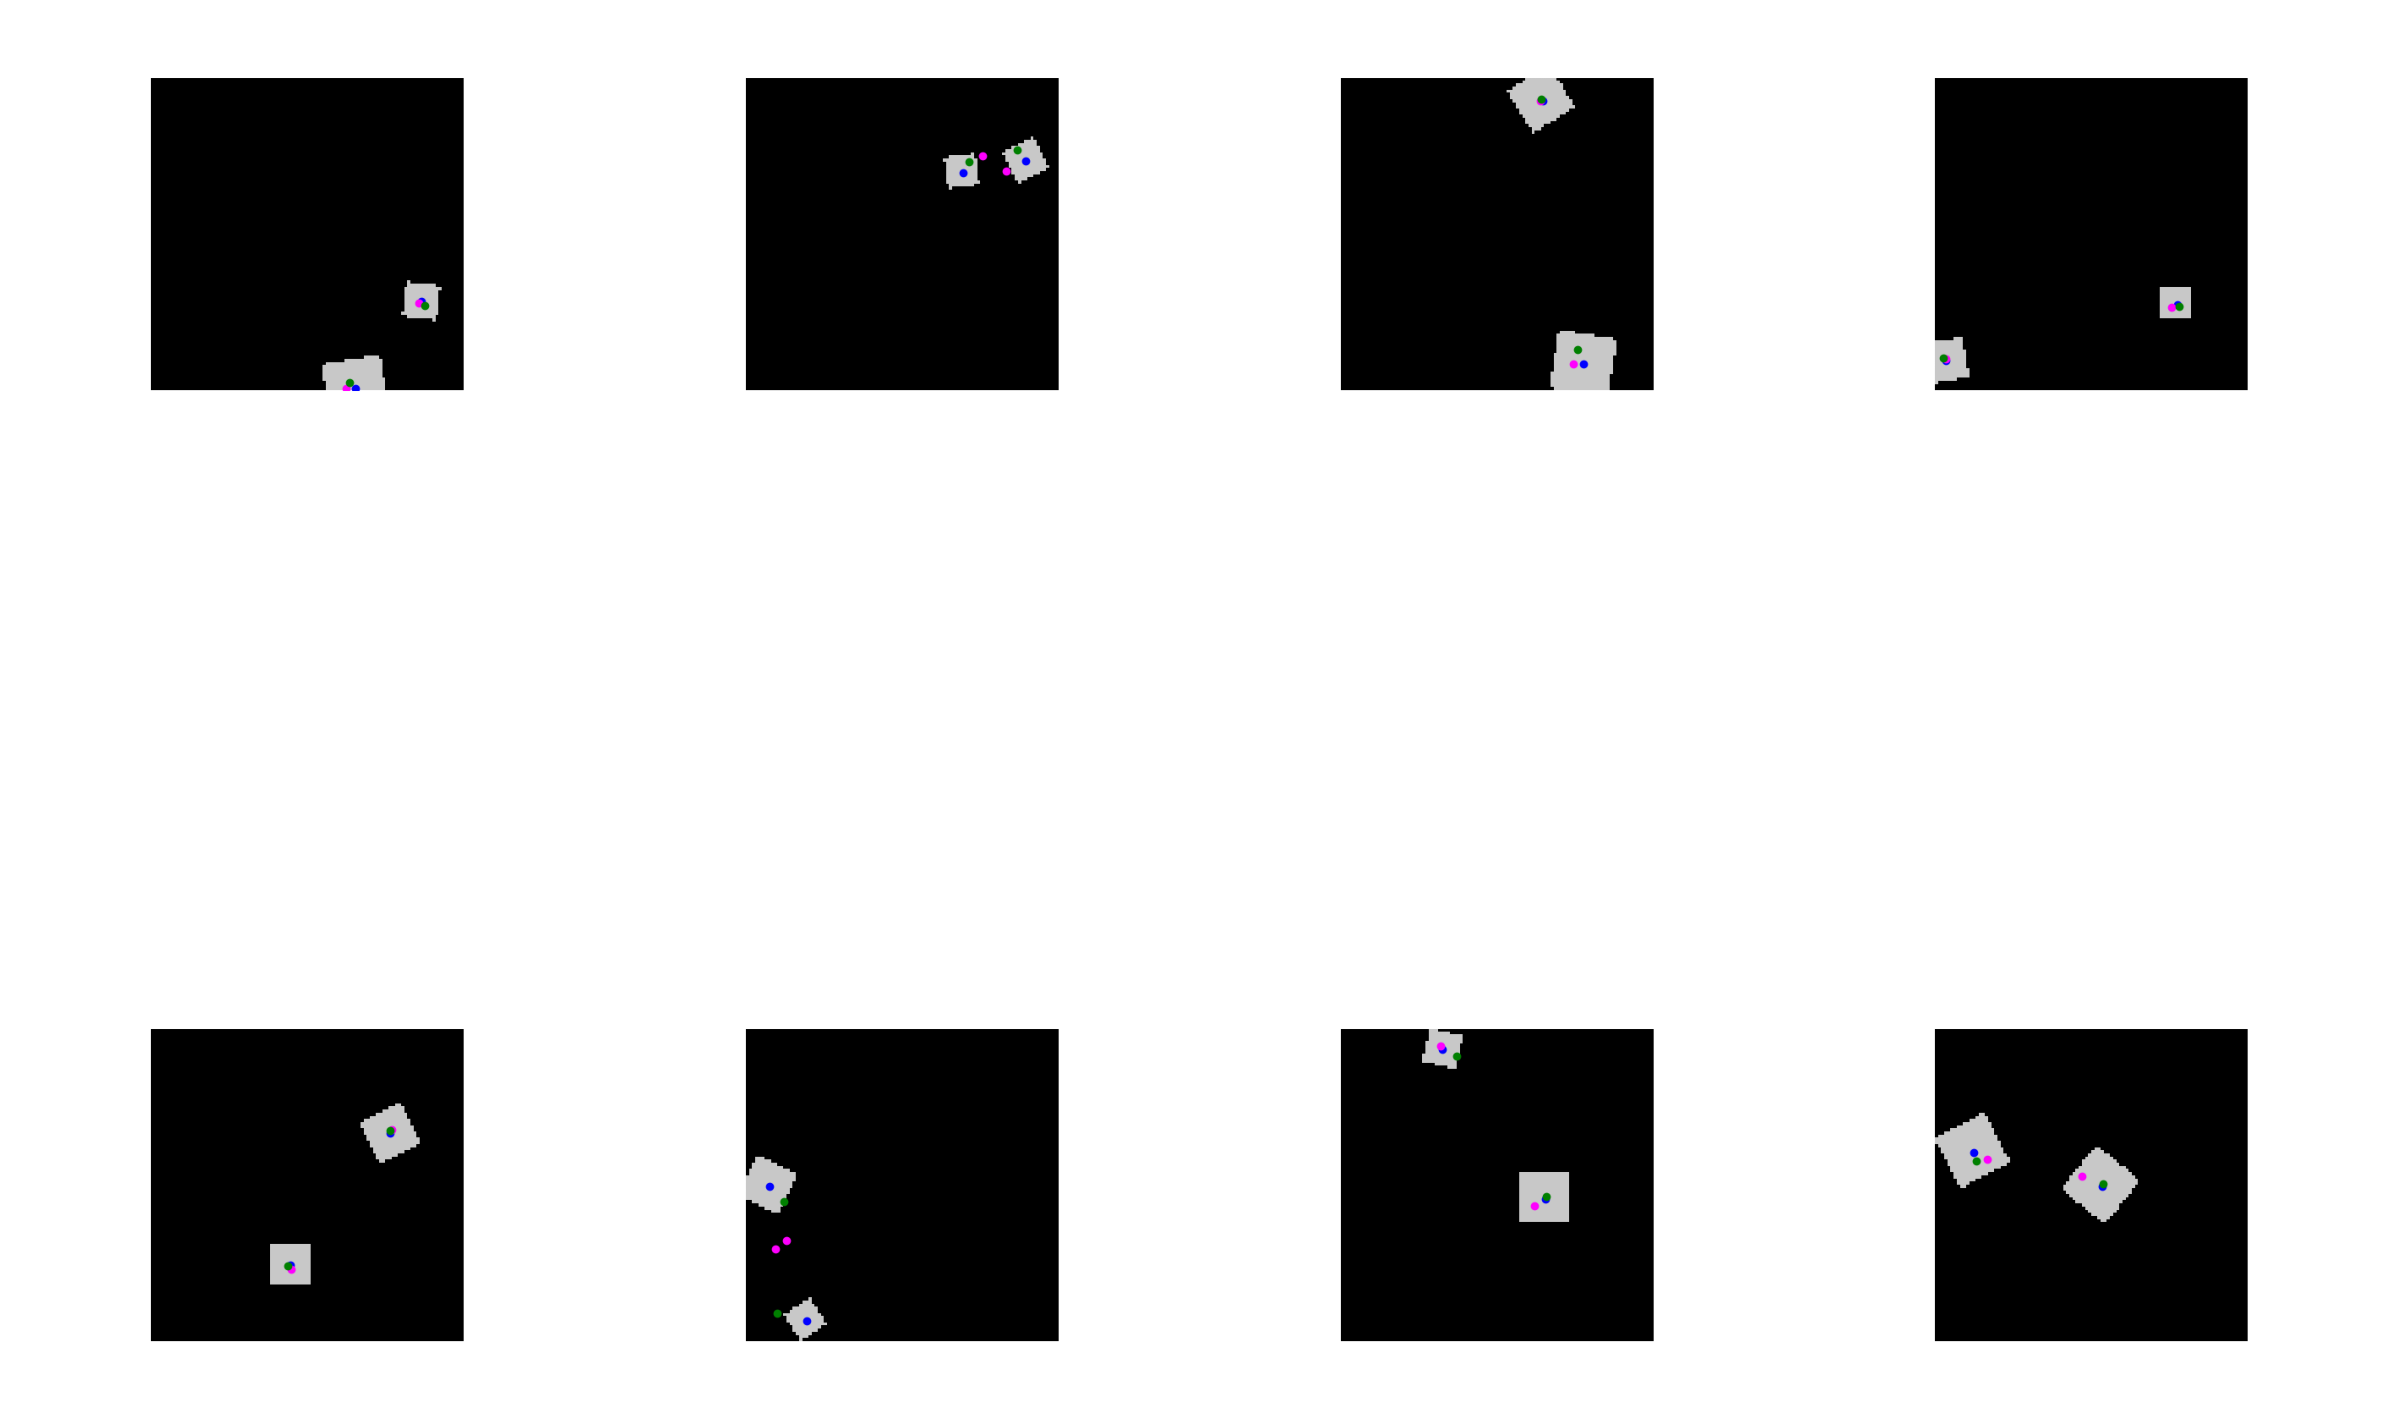

In [6]:
loaded_models = []

for model in [
    pred_model.ParallelPointPredictor(n_outputs=N_SQUARES),
    pred_model.SerialPointPredictor(n_outputs=N_SQUARES),
]:
    try:
        model.load_state_dict(torch.load(f"{str(model)}_weights.pth"))
        loaded_models.append(model)
    # except error for not finding file:
    except FileNotFoundError:
        pass

model_colors = ["magenta", "green"]

with torch.no_grad():
    for images, target_bboxes in test_dataloader:
        predicted_points = []

        for model in loaded_models:
            model.eval()
            pred_points = model(images)
            predicted_points.append(pred_points)

        predicted_points = torch.concatenate(predicted_points, dim=1)

        batch_size = pred_points.size(0)
        fig, ax = plt.subplots(2, batch_size // 2, figsize=(10, 10), dpi=300)
        # hspace:
        fig.subplots_adjust(hspace=-0.3, wspace=0.1)
        ax = ax.flatten()
        for i in range(batch_size):
            img = utils.draw_points_on_image(
                images[i].permute(1, 2, 0).numpy(),
                torch.concatenate((target_bboxes[i, :, :2], predicted_points[i])),
                ["blue"] * (N_SQUARES)
                + sum([[color] * N_SQUARES for color in model_colors], []),
            )
            ax[i].imshow(img)
            ax[i].axis("off")
        break

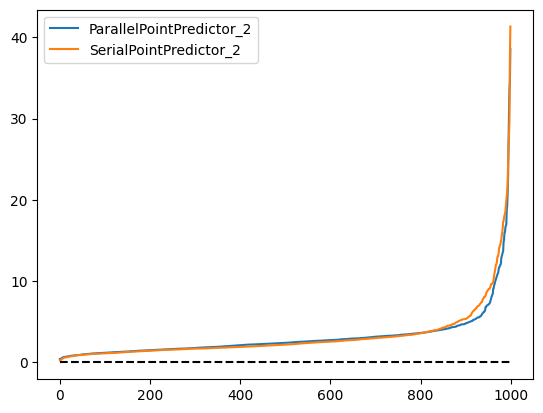

In [7]:
import torch

test_dataset = square_data_generator.SquareDataset(
    image_size=(100, 100),
    num_boxes=N_SQUARES,
    num_samples=1000,
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

losses = []
for i in range(len(loaded_models)):
    losses.append([])

with torch.no_grad():
    for images, target_bboxes in test_dataloader:
        for i, model in enumerate(loaded_models):
            model.eval()
            pred_points = model(images)
            loss = point_matching_loss_2_brute(pred_points, target_bboxes)
            losses[i].append(loss.item())

losses = torch.tensor(losses) / N_SQUARES

losses = torch.sort(losses, dim=1).values

for i in range(len(loaded_models)):
    plt.plot(losses[i].numpy(), label=str(loaded_models[i]))


# plt.plot(losses[1].numpy() - losses[0].numpy(), label="diff")
plt.hlines(0, 0, len(losses[0]), color="black", linestyle="--")

plt.legend()